<p align="center"><img src='https://drive.google.com/uc?export=view&id=1Q3X1N08GMDGuKZq_2Kh7ADqYFEdddg17'></p>

# **Clustering et Classification**

# 1 Preliminary

## 1.1 Context

La poule qui chante est une entreprise française d’agroalimentaire qui souhaite se développer à l'international. L'entreprise n'a pas encore identifier aucun pays ni aucun continent particuliers pour son développement. L'objectif de ce travail est de faire une étude de marché en proposant à l’entreprise une première analyse des groupements de pays qu'elle peut cibler pour exporter ses produits.

L'étude se fait en deux parties, la première vise à proposer une première analyse exploratoire de données. La seconde utilise des algorithmes d'apprentissage non supervisé, y compris la classification et le clustering pour segmenter les pays.

Dans ce notebook, nous allons surtout mettre en application deux algorithms de clustering, à savoir, Classification Ascendante Hiérarchique (CAH) et le K-Means, Ensuite, nous allons profiter de l'algorithme de l'Analyse en Composantes Principales (ACP) pour réduire la dimensionnalité de nos données. Enfin, nous allons re-tourner l'algorithme de K-Means sur les nouveaux composants et comparer les résultats.

## 1.2 Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt

import seaborn as sns

## 1.3 Options

In [ ]:
# Modifier un parametrage du pandas
pd.options.display.max_columns=999
# Afficher des décimaux sans format scientifique
pd.options.display.float_format = '{:.3f}'.format
# Identifier les valeurs qui seront considérées comme nulles
missing_values = ["n/a", "na", "--","nan","NaN", "NaT", " ", ""]

## 1.4 Functions

In [ ]:
# Cette fonction est intégralement copiée du cours Réalisez une analyse exploratoire de données
def correlation_graph(pca, 
                      x_y, 
                      features, 
                      figsize=[6, 6]) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x, y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=figsize)

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # le titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show()

In [ ]:
## Appliquer MinMax Scaler à un Dataframe
def min_max_scaler(df):
  clusters = df.index
  features = df.columns
  Y = df.values
  mm_scaler = MinMaxScaler((0, 10))
  mm_scaler.fit(Y)
  Y_scaled = mm_scaler.transform(Y)
  df_scaled = pd.DataFrame(Y_scaled)
  df_scaled.index = clusters
  df_scaled.columns = features
  return df_scaled

In [ ]:
# Visualiser une graphique à radar pour un Dataframe - Crédit : Mon mentor Eric Demangel
def radar_graph(df, figsize=[5, 5]):
  vars = list(df.columns)
  vars.append(vars[0])
  n_vars = len(vars)
  n_clusters = len(df)
  
  label_loc = np.linspace(start=0, stop=2 * np.pi, num=n_vars)

  plt.figure(figsize=figsize)
  plt.subplot(polar=True)
  for i in range(n_clusters):
    plt.plot(label_loc, np.append(df.values[i], df.values[i][0]), label=f'Groupe {df.index[i]}')

  plt.yticks([0, 2, 4, 6, 8, 10])
  lines, labels = plt.thetagrids(np.degrees(label_loc), labels=vars)
  plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.2))
  return plt

In [ ]:
# Cette fonction est intégralement copiée du cours Réalisez une analyse exploratoire de données
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca = None, 
                                labels = None,
                                clusters = None, 
                                alpha = 1,
                                figsize = [16, 8], 
                                marker = "." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
          plt.text(_x, _y+0.1, labels[i], fontsize='9', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

# 2 Data Preparation

## 2.1 Data Loading

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_trans_yj.csv", index_col = 'Zone',na_values = missing_values)

## 2.2 Data Overview

In [ ]:
data.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
Zone,,,,,,,,,
Afrique du Sud,1.045,1.958,1.869,0.251,-0.396,-0.219,1.439,0.845,1.030
Albanie,-0.066,0.151,-0.755,1.221,0.420,-0.473,-0.824,-1.273,-0.971
Algérie,-0.956,-0.888,0.267,1.089,-1.059,-0.541,1.095,-1.025,-0.971
Allemagne,0.163,2.018,1.820,1.603,0.711,1.616,1.761,-1.647,1.030
Angola,-0.556,1.790,-0.620,-1.324,-0.506,-0.543,0.714,0.337,-0.971


In [ ]:
data.tail()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
Zone,,,,,,,,,
Émirats arabes unis,1.363,1.925,-0.593,1.149,0.754,1.562,-0.342,-0.088,1.030
Équateur,0.152,-0.960,0.459,-0.643,-0.155,-0.205,0.104,0.932,-0.971
États-Unis d'Amérique,1.790,1.295,2.125,2.098,0.299,1.765,2.196,0.497,1.030
Éthiopie,-1.624,-0.924,-0.750,-1.244,-1.756,-1.187,1.922,0.021,-0.971
Îles Salomon,-1.154,-0.750,-0.817,-1.019,0.181,-0.863,-1.007,1.985,-0.971


In [ ]:
data.shape

(169, 9)

In [ ]:
data.columns

Index(['disponibilité_alimentaire', 'importations', 'production',
       'disponibilité_calories', 'stabilité_politique', 'pibph', 'population',
       'distance', 'exportateur'],
      dtype='object')

In [ ]:
data.dtypes

disponibilité_alimentaire    float64
importations                 float64
production                   float64
disponibilité_calories       float64
stabilité_politique          float64
pibph                        float64
population                   float64
distance                     float64
exportateur                  float64
dtype: object

In [ ]:
data.describe()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
count,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000
mean,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000
std,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003
min,-1.624,-0.960,-0.817,-2.383,-2.367,-1.245,-1.056,-1.797,-0.971
25%,-0.948,-0.853,-0.764,-0.790,-0.749,-0.913,-0.827,-0.727,-0.971
50%,0.073,-0.432,-0.517,-0.010,-0.034,-0.219,-0.342,0.079,-0.971
75%,0.794,0.878,0.517,0.864,0.797,0.853,0.698,0.757,1.030
max,2.277,2.034,2.125,2.118,2.276,1.986,2.217,2.582,1.030


## 2.3 Data Split

In [ ]:
features = data.columns
zones = data.index
X = data.values
X.shape

(169, 9)

# 3 Clustering

In [ ]:
data_clustered = data.copy()

## 3.1 Hierarchical Clustering

### Linkage

Tout d'abord, on va calculer les distances en utilisant la méthode de Ward



In [ ]:
Z = linkage(X, method="ward")
pd.DataFrame(Z)

,0,1,2,3
0,5.000,131.000,0.344,2.000
1,27.000,40.000,0.345,2.000
2,87.000,129.000,0.411,2.000
3,52.000,137.000,0.476,2.000
4,22.000,170.000,0.520,3.000
...,...,...,...,...
163,319.000,327.000,10.619,61.000
164,311.000,329.000,13.417,42.000
165,330.000,333.000,16.604,77.000
166,331.000,334.000,20.232,108.000


### Dendrogram

On va ensuite afficher le dendrogramme:

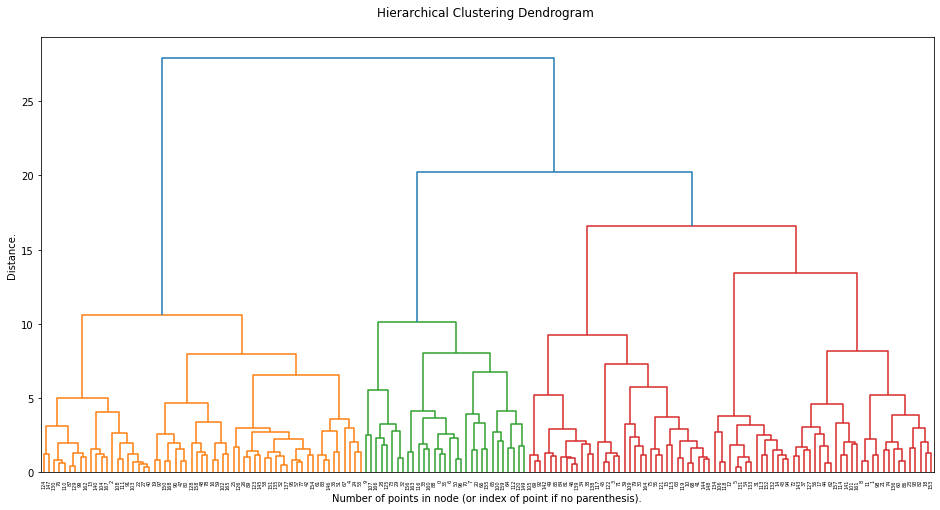

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

dg = dendrogram(Z, ax=ax)

plt.title("Hierarchical Clustering Dendrogram \n")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

Le dendrogramme semble pertinent mais sa profondeur le rend illisible. On peut jouer sur différents paramètres pour obtenir un dendrogramme plus lisible

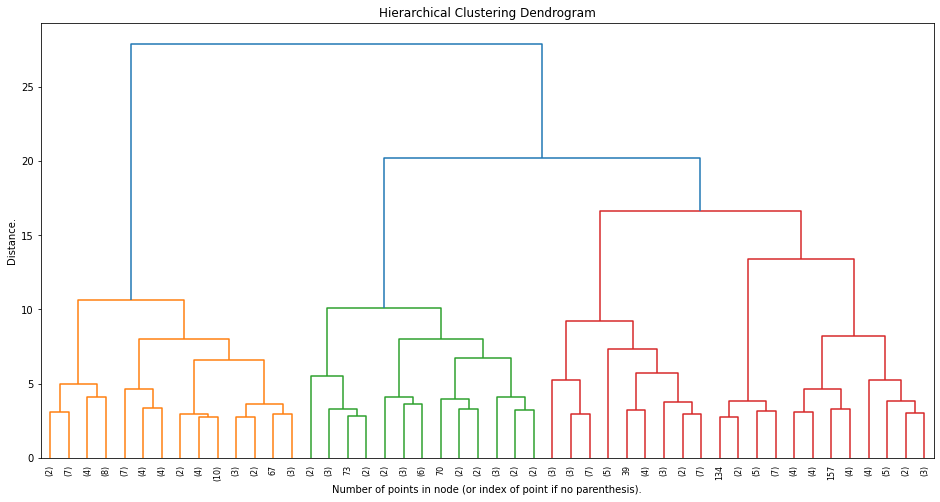

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

dg = dendrogram(Z, p=48, truncate_mode="lastp", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

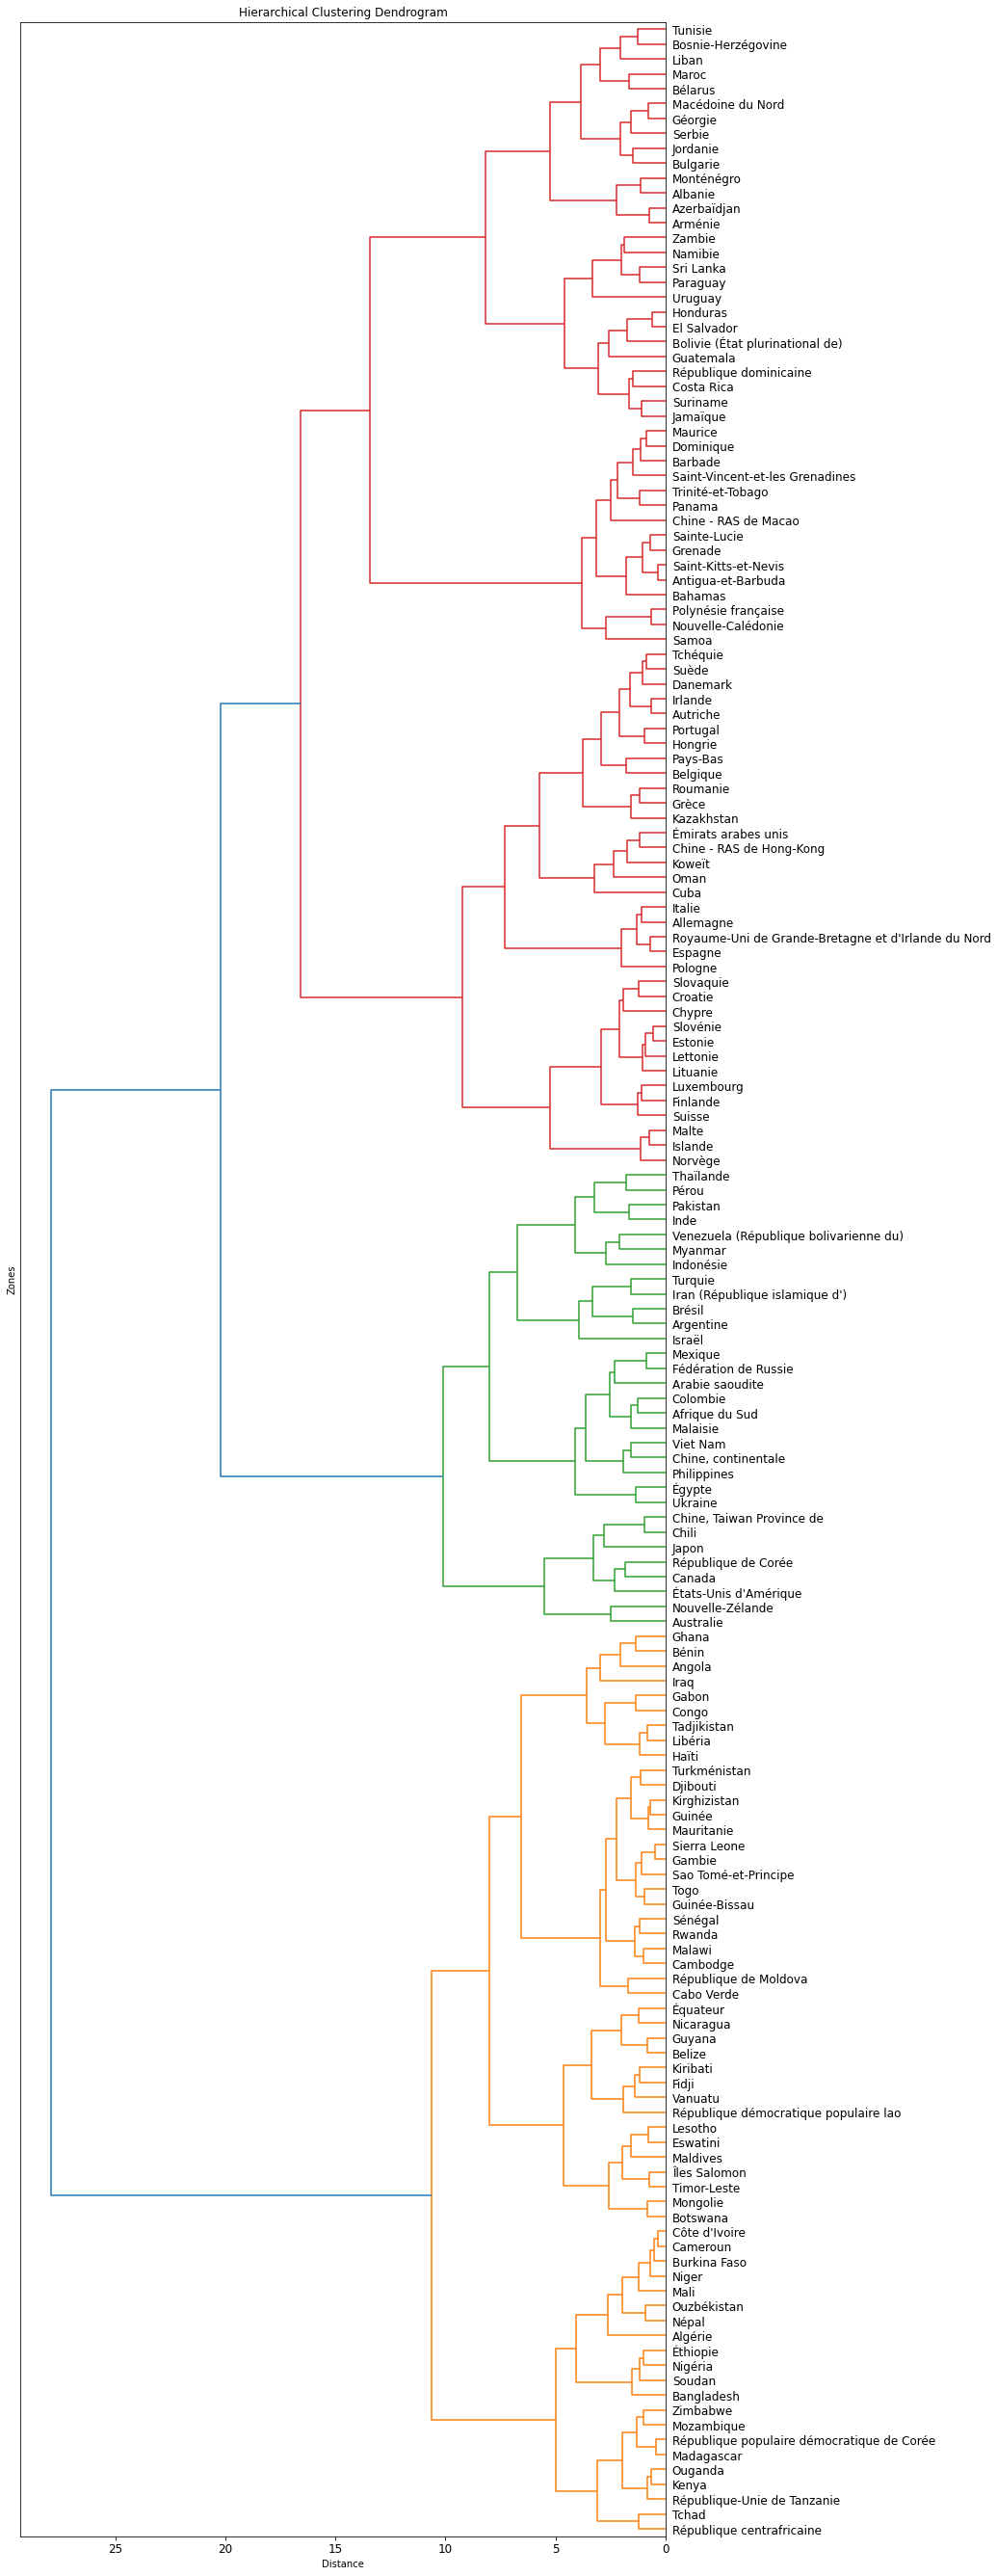

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 48))

dg = dendrogram(Z, ax=ax, labels=zones, orientation = "left")

plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Zones")
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

Selon la dondrogramme, on peut effectivement considérer une partition à 3, 4 et voire 5 clusters. On va cependant retenir une partition à 4 cluster qui semble la plus pertinante et la plus marquante.

### Clustering Implementation

On définit le nombre de clusters que l'on veut mettre en oeivre

In [ ]:
k = 4

On va ensuite entrainer un estimateur pour chaque nombre de cluster

In [ ]:
cah = AgglomerativeClustering(n_clusters = k, linkage = "ward")
cah.fit(X)
data_clustered[f'cluster_cah_{k}'] = cah.labels_

Voici les resultats pour les differents nombres de clusters

In [ ]:
data_clustered.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur,cluster_cah_4
Zone,,,,,,,,,,
Afrique du Sud,1.045,1.958,1.869,0.251,-0.396,-0.219,1.439,0.845,1.030,2
Albanie,-0.066,0.151,-0.755,1.221,0.420,-0.473,-0.824,-1.273,-0.971,0
Algérie,-0.956,-0.888,0.267,1.089,-1.059,-0.541,1.095,-1.025,-0.971,1
Allemagne,0.163,2.018,1.820,1.603,0.711,1.616,1.761,-1.647,1.030,3
Angola,-0.556,1.790,-0.620,-1.324,-0.506,-0.543,0.714,0.337,-0.971,1


On aperçoit que l'algorithme réalise le clustering en donnant un nombre pour chaque cluster. Cependant, ce n'est pas l'idéal. En effet, il n'y a pas d'ordre entre les clusters. Le cluster 0 n'est pas supérieur au cluster 1 par exemple. Pour être plus clair, on va utiliser des lettres plutôt que des nombres

In [ ]:
labels_map = {i:j for i, j in enumerate(list("abcdefgh"))}
labels = [labels_map[i] for i in cah.labels_]
data_clustered[f'cluster_cah_{k}'] = labels

In [ ]:
data_clustered.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur,cluster_cah_4
Zone,,,,,,,,,,
Afrique du Sud,1.045,1.958,1.869,0.251,-0.396,-0.219,1.439,0.845,1.030,c
Albanie,-0.066,0.151,-0.755,1.221,0.420,-0.473,-0.824,-1.273,-0.971,a
Algérie,-0.956,-0.888,0.267,1.089,-1.059,-0.541,1.095,-1.025,-0.971,b
Allemagne,0.163,2.018,1.820,1.603,0.711,1.616,1.761,-1.647,1.030,d
Angola,-0.556,1.790,-0.620,-1.324,-0.506,-0.543,0.714,0.337,-0.971,b


### Clusters Visualisation

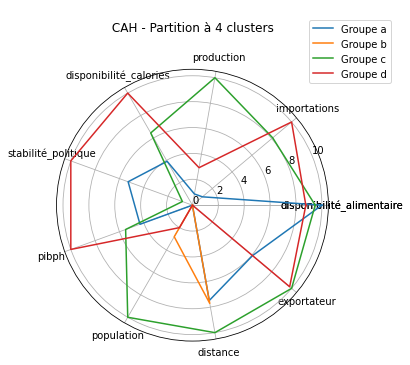

In [ ]:
grouped = data_clustered.groupby(f'cluster_cah_{k}').mean()
grouped_scaled = min_max_scaler(grouped)
radar_graph(grouped_scaled)
plt.title(f'\n CAH - Partition à {k} clusters \n')
plt.show()

### Clusters Analysis

- Cluster a : Les pays dans ce cluster ne sont pas du tout intérssants de point de vue commercial, **à éviter**.
- Cluster b : Les pays dans ce cluster sont parmi ceux qui ont le plus besoin de viande de volailles. Les pays de ce cluster pourraient ouvrir une opportunité commerciale considérable si une bonne stratégie de vente est retenue, comme proposer des produits **bas de gamme**.
- Cluster c : Ce cluster est particulier. Les pays dans ce cluster peuvent être ciblés, mais ça sera un **vrai challenge**. L'économie d'échelle pourrait être mise à profit, si jamais, car ils ont une très grande population. Attention, ils sont fragiles politiqument.
- Cluster d : Ce cluster représente notamment les pays les plus intérssants. ce seront propablement les clients naturles de nos produits. Il peuvent ouvrire une bonne opportunité commerciale à proximité. Penser à proposer des produits **haut de gamme**.

Voici les pays de chaque cluster :

In [ ]:
for cluster in data_clustered['cluster_cah_4'].unique():
  countries = list(data_clustered[data_clustered['cluster_cah_4'] == cluster].index)
  print('Cluster :', cluster)
  print('Nombre de pays : ', len(countries))
  print(countries)
  print('\n')

Cluster : c
Nombre de pays :  31
['Afrique du Sud', 'Arabie saoudite', 'Argentine', 'Australie', 'Brésil', 'Canada', 'Chili', 'Chine, Taiwan Province de', 'Chine, continentale', 'Colombie', 'Fédération de Russie', 'Inde', 'Indonésie', "Iran (République islamique d')", 'Israël', 'Japon', 'Malaisie', 'Mexique', 'Myanmar', 'Nouvelle-Zélande', 'Pakistan', 'Philippines', 'Pérou', 'République de Corée', 'Thaïlande', 'Turquie', 'Ukraine', 'Venezuela (République bolivarienne du)', 'Viet Nam', 'Égypte', "États-Unis d'Amérique"]


Cluster : a
Nombre de pays :  42
['Albanie', 'Antigua-et-Barbuda', 'Arménie', 'Azerbaïdjan', 'Bahamas', 'Barbade', 'Bolivie (État plurinational de)', 'Bosnie-Herzégovine', 'Bulgarie', 'Bélarus', 'Chine - RAS de Macao', 'Costa Rica', 'Dominique', 'El Salvador', 'Grenade', 'Guatemala', 'Géorgie', 'Honduras', 'Jamaïque', 'Jordanie', 'Liban', 'Macédoine du Nord', 'Maroc', 'Maurice', 'Monténégro', 'Namibie', 'Nouvelle-Calédonie', 'Panama', 'Paraguay', 'Polynésie française',

Enfin et pour mieu comprendre les caractéristique de chaque cluster, voici une graphique pour montrer la distribution de chaque variable par cluster.

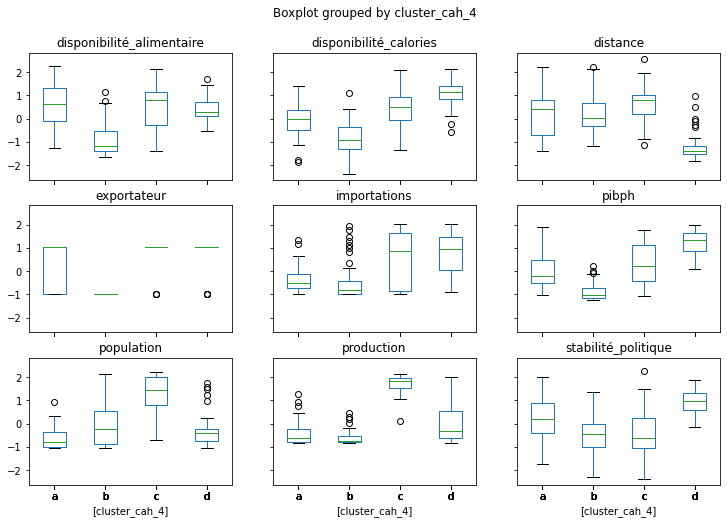

In [ ]:
data_clustered.boxplot(by='cluster_cah_4', grid=False, figsize=(12, 8))
plt.show()

## 3.2 K-Means Clustering

### Determining the number of clusters

Tout d'abord, on définit une liste du nombre de clusters que l'on va tester

In [ ]:
k = range(2, 13)

Pour nous aider à choisir un nombre optimal de clusters, on va utiliser 4 techinques: la méthode du coude, l'indice Davies-Bouldin, le coefficient de silhouette, et l'indice Calinski-Harabasz

**Elbow Methode (la méthode du coude)**

On commence par entrainer un k-means spécifique pour chaque valeur de k et on stocke son inertie

In [ ]:
intertia = []
for n in k :
  kmeans = KMeans(n_clusters = n, random_state = 42)
  kmeans.fit(X)
  intertia.append(kmeans.inertia_)

On affiche ensuite le resultat

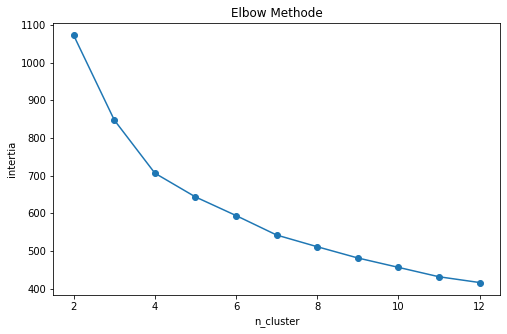

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.set_title("Elbow Methode")
ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k, intertia, marker='o')

On voit une cassure dans la courbe à 4 clusters. Autrement dit, l'inertie diminue rapidement entre 4 et 5 clusters. On pourrait donc considérer qu'un nombre de clusters à 4 sera optimal. On voit également une petite coude moins marquante à 7. 

**Davies Bouldin Index**

L'indice Davies Bouldin est calculé comme la similarité moyenne de chaque cluster avec son cluster le plus similaire.

Le score minimum est de zéro. Un indice Davies-Bouldin plus faible montre une meilleure séparation entre les clusters, autrement dit, une meilleure partition. 

On entraine un k-means spécifique pour chaque valeur de k et on stocke le score Davies Bouldin.

In [ ]:
db = []
for n in k:
    kmeans = KMeans(n_clusters = n, random_state = 42)
    kmeans.fit(X)
    labels = kmeans.labels_
    db.append(davies_bouldin_score(X, labels))

On affiche le resultat

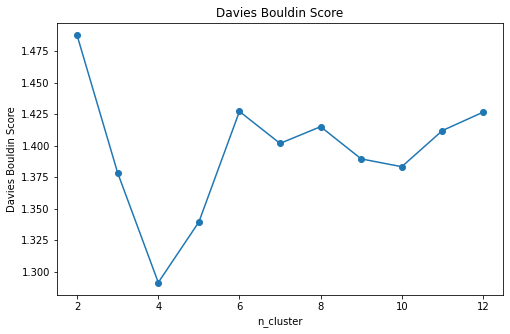

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.set_title("Davies Bouldin Score")
ax.set_ylabel("Davies Bouldin Score")
ax.set_xlabel("n_cluster")
ax = plt.plot(k, db, marker='o')

L'indice Davies Bouldin montre que 4 est le nombre de clusters le plus optimal. Cela valide alors le resultat de la methode du coude. On aperçoit aussi deux petits creux moins importants à 7, 9 et 10. 

**Silhouette Score**

Le score Silhouette mesure la divergence entre les clusters en tenant compte à la fois des distances intra-clusters et inter-clusters. Un score plus élevé signifie une meilleure partition.

In [ ]:
sil = []
for n in k:
    kmeans = KMeans(n_clusters = n, random_state = 42)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

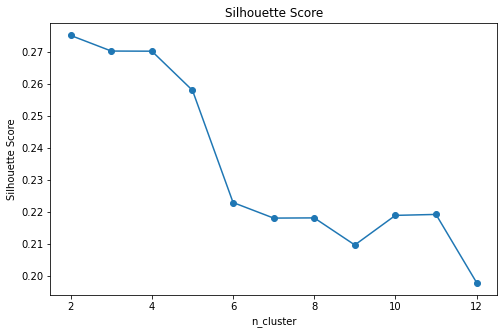

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.set_title("Silhouette Score")
ax.set_ylabel("Silhouette Score")
ax.set_xlabel("n_cluster")
ax = plt.plot(k, sil, marker='o')

On voit un pic à 4. Cela signifie que 4 clusters est la meilleure partition. On peut aussi considérer 3 clusters, voire 10 et 11 clusters. 

**Calinski-Harabasz Index**

L'indice Calinski-Harabasz est le rapport de la somme de la dispersion inter-clusters et de la dispersion intra-cluster pour tous les clusters. Un score plus élevé correspond à des clusters mieux définis.

In [ ]:
cali = []
for n in k:
    kmeans = KMeans(n_clusters = n, random_state = 42)
    kmeans.fit(X)
    cali.append(calinski_harabasz_score(X, kmeans.labels_))

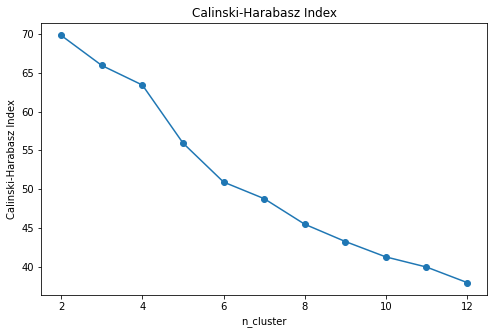

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.set_title("Calinski-Harabasz Index")
ax.set_ylabel("Calinski-Harabasz Index")
ax.set_xlabel("n_cluster")
ax = plt.plot(k, cali, marker='o')

On voit que une partition à 2 clusters donne le meilleur score, puis, vient une partition à 3 et 4 clusters. Le score tombe rapidement au delà. On peut donc considérer une partition à 3 et 4 clusters (une partition en 2 cluster ne sera pas très utile). On aperçoit aussi un petit pic moins marquant à 7. 

Voici ce que nous obtenons en utilisant les quatre techniques pour décider du nombre de clusters :
- La méthode de la coude : 4 clusters. On peut aussi considérer 7 clusters.
- L'indice Davies Bouldin : 4 clusters. On peut aussi considérer 7, 9 et 10 clusters
- Le score Silhouette : 4 clusters. On peut aussi considérer 3, 10 et 11 clusters.
- L'indice Calinski-Harabasz : 2, 3, 4 et voire 7 clusters

On remarque que toutes les analyses s'accordent unanimement sur 4 clusters comme un nombre optimal. On va cependant tester une partition à 3, 4 et 7 clusters et comparer les resultats. 

### Clustering Implementation

On définit une liste du nombre de clusters que nous semble les plus pertinents 

In [ ]:
n_clusters = [3, 4, 7]

On va ensuite entrainer un estimateur pour chaque nombre de cluster

In [ ]:
for n_cluster in n_clusters:
  kmeans = KMeans(n_clusters=n_cluster, random_state = 42)
  kmeans.fit(X)
  labels = [labels_map[i] for i in kmeans.labels_]
  data_clustered[f'cluster_kmeans_{n_cluster}'] = labels

Voici les resultats pour les differents nombres de clusters

In [ ]:
data_clustered.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur,cluster_cah_4,cluster_kmeans_3,cluster_kmeans_4,cluster_kmeans_7
Zone,,,,,,,,,,,,,
Afrique du Sud,1.045,1.958,1.869,0.251,-0.396,-0.219,1.439,0.845,1.030,c,c,d,f
Albanie,-0.066,0.151,-0.755,1.221,0.420,-0.473,-0.824,-1.273,-0.971,a,b,c,d
Algérie,-0.956,-0.888,0.267,1.089,-1.059,-0.541,1.095,-1.025,-0.971,b,a,a,c
Allemagne,0.163,2.018,1.820,1.603,0.711,1.616,1.761,-1.647,1.030,d,c,d,e
Angola,-0.556,1.790,-0.620,-1.324,-0.506,-0.543,0.714,0.337,-0.971,b,a,a,a


On aperçoit que l'algorithme réalise le clustering en donnant un nombre pour chaque cluster. Cependant, ce n'est pas l'idéal. En effet, il n'y a pas d'ordre entre les clusters. Le cluster 0 n'est pas supérieur au cluster 1 par exemple. Pour être plus clair, on va utiliser des lettres plutôt que des nombres

### Clusters Visualisation

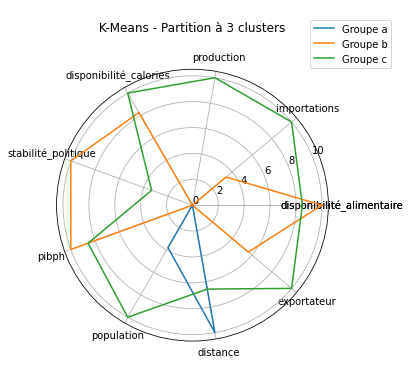

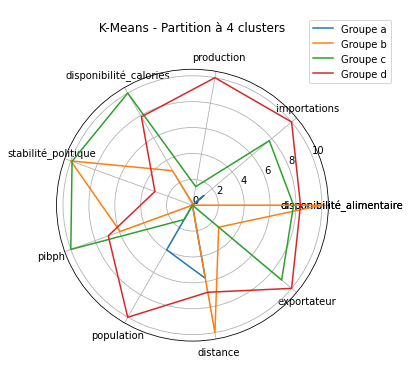

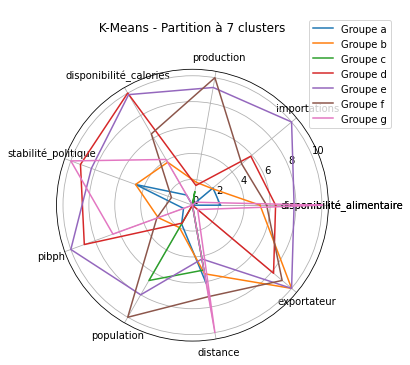

In [ ]:
for n_cluster in n_clusters:
  grouped = data_clustered.groupby(f'cluster_kmeans_{n_cluster}').mean()
  grouped_scaled = min_max_scaler(grouped)
  radar_graph(grouped_scaled)
  plt.title(f'\n K-Means - Partition à {n_cluster} clusters \n')
  plt.show()

### Clusters Analysis

On va retrnir une partition à 4 clusters parce qu'elle semble la plus pertinente et la plus simple à intérpreter.

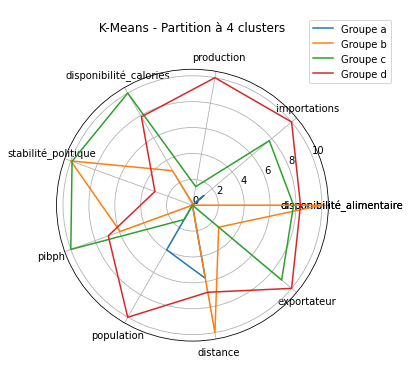

In [ ]:
n = 4
grouped = data_clustered.groupby(f'cluster_kmeans_{n}').mean()
grouped_scaled = min_max_scaler(grouped)
radar_graph(grouped_scaled)
plt.title(f'\n K-Means - Partition à {n} clusters \n')
plt.show()

- Cluster a : Les pays dans ce cluster sont parmi ceux qui ont le plus besoin de viande de volailles. Les pays de ce cluster pourraient ouvrir une opportunité commerciale considérable si une bonne stratégie de vente est retenue, comme proposer des produits **bas de gamme**.
- Cluster b : Les pays dans ce cluster ne sont pas du tout intérssants de point de vue commercial, **à éviter**.
- Cluster c : Ce cluster sera plutôt prioritaire. Il représente les pays les plus intérssants. ce seront propablement les clients naturels de nos produits. Il peuvent ouvrire une bonne opportunité commerciale à proximité. Penser à proposer des produits **haut de gamme**.
- Cluster d : Ce cluster est particulier. Les pays dans ce cluster peuvent être ciblés, mais ça sera un **vrai challenge**. L'économie d'échelle pourrait être mise à profit, si jamais, car ils ont une très grande population. Attention, ils sont fragiles politiqument.

Voici la liste de pays de chaque cluster :

In [ ]:
for cluster in data_clustered['cluster_kmeans_4'].unique():
  countries = list(data_clustered[data_clustered['cluster_kmeans_4'] == cluster].index)
  print('Cluster :', cluster)
  print('Nombre de pays : ', len(countries))
  print(countries)
  print('\n')

Cluster : d
Nombre de pays :  35
['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine', 'Australie', 'Brésil', 'Canada', 'Chili', 'Chine, Taiwan Province de', 'Chine, continentale', 'Colombie', 'Espagne', 'Fédération de Russie', 'Guatemala', 'Inde', 'Indonésie', "Iran (République islamique d')", 'Italie', 'Japon', 'Malaisie', 'Maroc', 'Mexique', 'Myanmar', 'Pakistan', 'Philippines', 'Pologne', 'Pérou', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'République de Corée', 'Thaïlande', 'Turquie', 'Ukraine', 'Viet Nam', 'Égypte', "États-Unis d'Amérique"]


Cluster : c
Nombre de pays :  41
['Albanie', 'Autriche', 'Belgique', 'Bosnie-Herzégovine', 'Bulgarie', 'Bélarus', 'Chine - RAS de Hong-Kong', 'Chypre', 'Croatie', 'Cuba', 'Danemark', 'Estonie', 'Finlande', 'Grèce', 'Géorgie', 'Hongrie', 'Irlande', 'Islande', 'Israël', 'Jordanie', 'Kazakhstan', 'Koweït', 'Lettonie', 'Lituanie', 'Luxembourg', 'Macédoine du Nord', 'Malte', 'Monténégro', 'Norvège', 'Oman', 'Pays-Bas', 'Port

Enfin et pour mieu comprendre les caractéristique de chaque cluster, voici une graphique pour montrer la distribution de chaque variable au sein de chaque cluster.

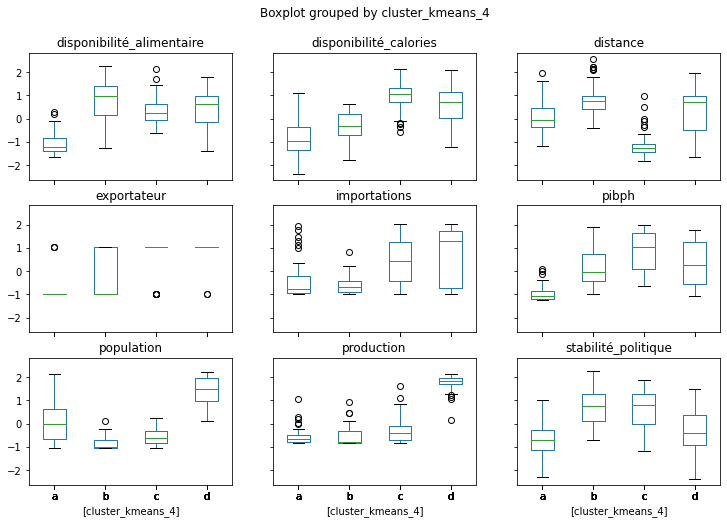

In [ ]:
data_clustered.boxplot(by='cluster_kmeans_4', grid=False, figsize=(12, 8))
plt.show()

## 3.3 Comparing Hierarchical and K-Means Clustering

Text(0.5, 1.0, '\n Hierarchical clustering (4 clusters) \n')

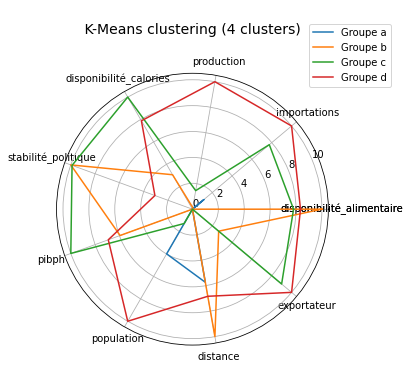

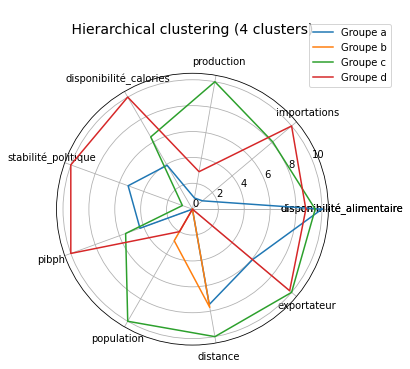

In [ ]:
grouped_kmeans = data_clustered.groupby(f'cluster_kmeans_4').mean()
grouped_kmeans_scaled = min_max_scaler(grouped_kmeans)
grouped_cah = data_clustered.groupby(f'cluster_cah_4').mean()
grouped_cah_scaled = min_max_scaler(grouped_cah)

radar_graph_kmeans = radar_graph(grouped_kmeans_scaled)
radar_graph_kmeans.title('\n K-Means clustering (4 clusters) \n', size=14)

radar_graph_cah = radar_graph(grouped_cah_scaled)
radar_graph_cah.title('\n Hierarchical clustering (4 clusters) \n', size=14)

# 4 Principal component analysis (PCA)

## 4.1 Scaling

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X)

StandardScaler()

In [ ]:
X_scaled = scaler.transform(X)

In [ ]:
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8
mean,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## 4.2 PCA Implementation

In [ ]:
pca = PCA()

In [ ]:
pca.fit(X_scaled)

PCA()

In [ ]:
pca.n_samples_

169

## 4.3 Explained variance & scree plot

In [ ]:
pca.explained_variance_ratio_

array([0.39497595, 0.24888803, 0.13112966, 0.06830546, 0.05002223,
       0.04844304, 0.02923959, 0.0192742 , 0.00972184])

In [ ]:
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree

array([39.5 , 24.89, 13.11,  6.83,  5.  ,  4.84,  2.92,  1.93,  0.97])

In [ ]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 40.,  64.,  78.,  84.,  89.,  94.,  97.,  99., 100.])

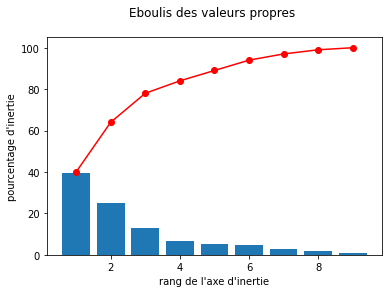

In [ ]:
x_list = range(1, len(scree)+1)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres \n")
plt.show()

## 4.4 Components

In [ ]:
pcs = pca.components_

In [ ]:
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

In [ ]:
pcs.shape

(9, 9)

## 4.5 Correlation graph

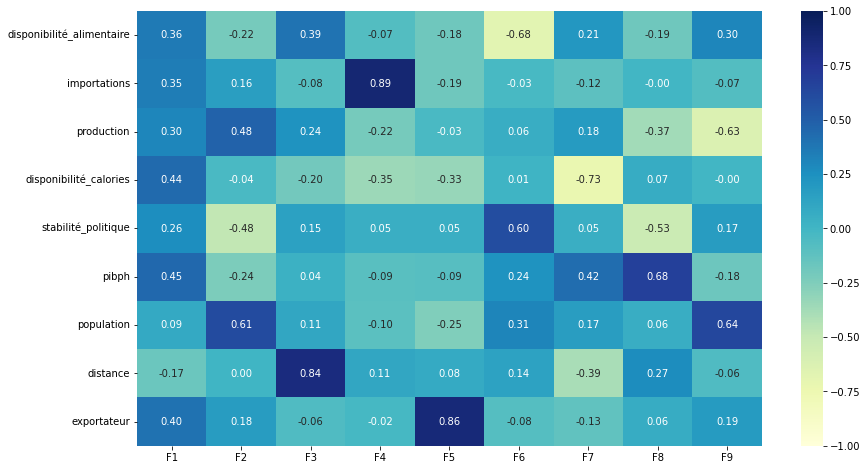

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="YlGnBu", fmt="0.2f")
plt.show()

Interprétation des composants (de F1 à F5): 
- F1 : ce composant traduit plutôt la puissance économique et la disponibilité en viande de volailles et celle en colories par personne.
- F2 : ce composant traduit la population et la taille de production. 
- F3 : représente la distance de France
- F4 : représente la taille d'importation en viande de volailles
- F5 : si un pays est exportateur de la viande de volailles ou non


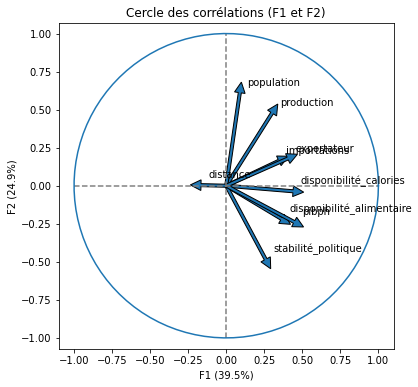

In [ ]:
x_y = (0, 1)
correlation_graph(pca, x_y, features)

Sur le premier plan factoriel, on voit que les variables les plus corrélées positivement à F1 sont :
- disponibilité_calories
- disponibilité_alimentaire
- exportateur
- pibph

On apérçoit que que toutes ces variables ont un sens commun, c’est-à-dire une notion qui les unit. C’est plutôt l'abondance en viande de volaille ou dans un jargon économique **la taille de l'offre**. 

Intuitivement, on peut dire que plus un pays est puissant économiquement, plus il a de disponibilité en calories et en viande de volailles par personne. C'est totalement logique!


Concernant F2, on voit que les variables les plus corrélées positivement sont : 
- population
- production

On voit également que la variable stabilité politique a une corrélation négative à F2.

On peut alors comprendre que plus un pays a de population plus il produit de la viande de volailles, et moins il est stable politiquement. 

Si on veut intégrer ces variables dans une notion commune, on peut parler de **la taille du marché**. Un pays avec une grande population représente un marché énorme. 

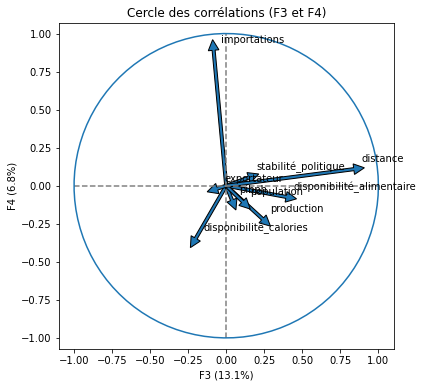

In [ ]:
x_y = (2, 3)
correlation_graph(pca, x_y, features)

Sur le deuxième plan factoriel, on voit que la variable distance et la varialbe disponibilité alimentaire sont les plus corrélées positivement à F3. On peut dire que plus le pays est loin de France, plus il a de disponibilité en viande de volailles, autrement dit, moins il est intéressant de point de vue commercial. La notion de distance est souvent liée à **la difficulté logistique** qunad on fait de l'export. 

Quant à F4, celui-ci est largement dominé par la variable importation. On voit aussi que la variable disponibilité en colories est anti-corrélée à F4. On peut alors comprendre que plus un pays importe, moins il a de disponibilité en calories par personne. Tout à fait logique! Si on veut donner une notion plus concrète à ce composant, ce sera **la taille de la demande**.

Pour résumer, voici les notions qu'on peut donner à chacun de 4 premiers composants :
- F1 : la taille de l'offre
- F2 : la taille du marché
- F3 : la difficulté logistique
- F4 : la taille de la demande

## 4.6 Projection

In [ ]:
X_proj = pca.transform(X_scaled)

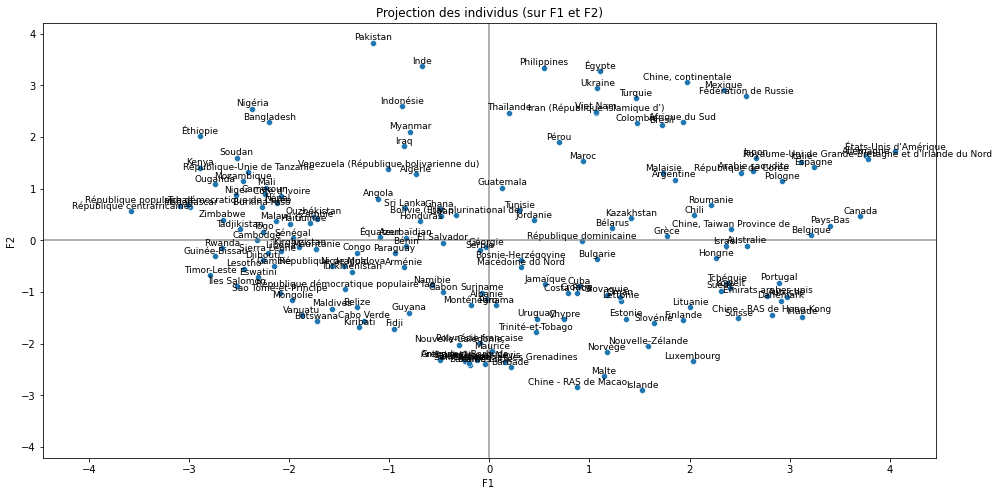

In [ ]:
x_y = (0, 1)
display_factorial_planes(X_proj, x_y, labels=zones)

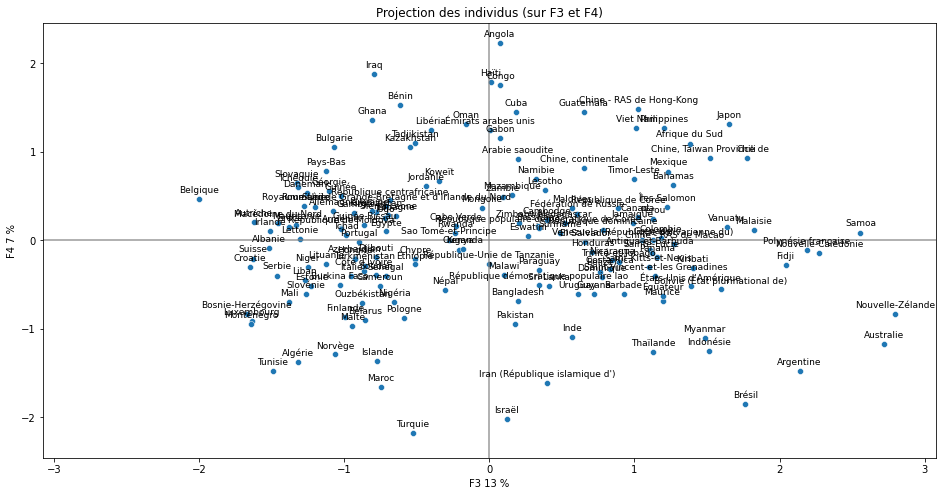

In [ ]:
x_y = (2, 3)
display_factorial_planes(X_proj, x_y, pca, labels=zones)

# 5 Clustering with PCA

## 5.1 PCA

On va prendre les 4 premiers composants portant 84% d'informations

In [ ]:
pca = PCA(n_components = 4)

In [ ]:
pca.fit(X_scaled)

PCA(n_components=4)

In [ ]:
scores_pca = pca.transform(X_scaled)

## 5.2 K-Means

In [ ]:
intertia = []
db = []
sil = []
cali = []

for n in k :
  kmeans_pca = KMeans(n_clusters = n, random_state = 42)
  kmeans_pca.fit(scores_pca)
  labels = kmeans_pca.labels_
  intertia.append(kmeans_pca.inertia_)
  db.append(davies_bouldin_score(scores_pca, labels))
  sil.append(silhouette_score(scores_pca, labels, metric = 'euclidean'))
  cali.append(calinski_harabasz_score(scores_pca, labels))

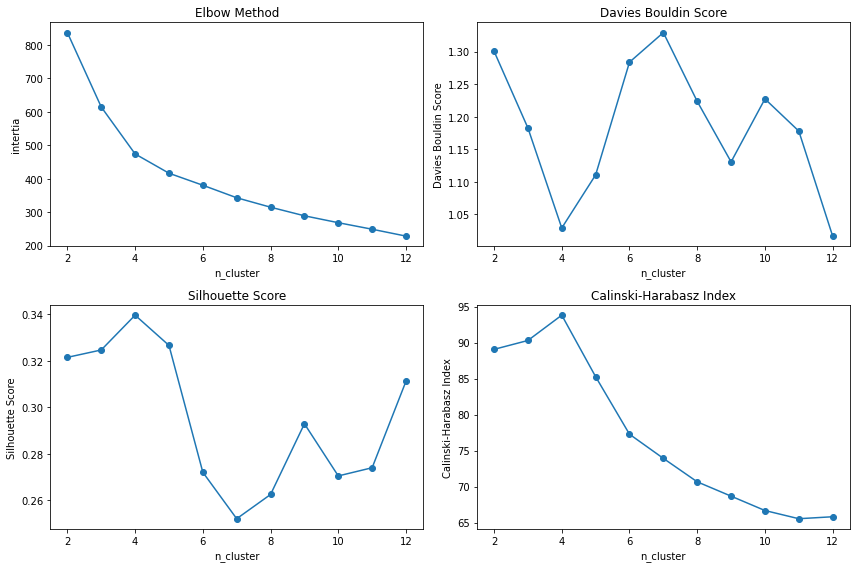

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

axes[0, 0].set_ylabel("intertia")
axes[0, 0].set_xlabel("n_cluster")
axes[0, 0].plot(k, intertia, marker='o')
axes[0, 0].set_title("Elbow Method")

axes[0, 1].set_ylabel("Davies Bouldin Score")
axes[0, 1].set_xlabel("n_cluster")
axes[0, 1].plot(k, db, marker='o')
axes[0, 1].set_title("Davies Bouldin Score")

axes[1, 0].set_ylabel("Silhouette Score")
axes[1, 0].set_xlabel("n_cluster")
axes[1, 0].plot(k, sil, marker='o')
axes[1, 0].set_title("Silhouette Score")

axes[1, 1].set_ylabel("Calinski-Harabasz Index")
axes[1, 1].set_xlabel("n_cluster")
axes[1, 1].plot(k, cali, marker='o')
axes[1, 1].set_title("Calinski-Harabasz Index")

fig.tight_layout()
plt.show()

In [ ]:
data_pca = pd.DataFrame(scores_pca)
data_pca.index = zones
data_pca.columns = ["offre", 'taille_du_marché', 'difficulté_logistique', 'demande']
data_pca.head()

,offre,taille_du_marché,difficulté_logistique,demande
Zone,,,,
Afrique du Sud,1.934,2.287,1.381,1.093
Albanie,-0.020,-1.138,-1.518,-0.086
Algérie,-0.736,1.284,-1.319,-1.369
Allemagne,3.762,1.630,-1.075,0.335
Angola,-1.109,0.805,0.071,2.232


**Clustering Implementation**

In [ ]:
kmeans_pca = KMeans(n_clusters = 4, random_state = 42)
kmeans_pca.fit(scores_pca)
labels = [labels_map[i] for i in kmeans_pca.labels_]
data_pca['cluster_kmeans'] = labels

In [ ]:
data_pca.head()

,offre,taille_du_marché,difficulté_logistique,demande,cluster_kmeans
Zone,,,,,
Afrique du Sud,1.934,2.287,1.381,1.093,c
Albanie,-0.020,-1.138,-1.518,-0.086,d
Algérie,-0.736,1.284,-1.319,-1.369,a
Allemagne,3.762,1.630,-1.075,0.335,c
Angola,-1.109,0.805,0.071,2.232,a


**Clusters Visualisation**

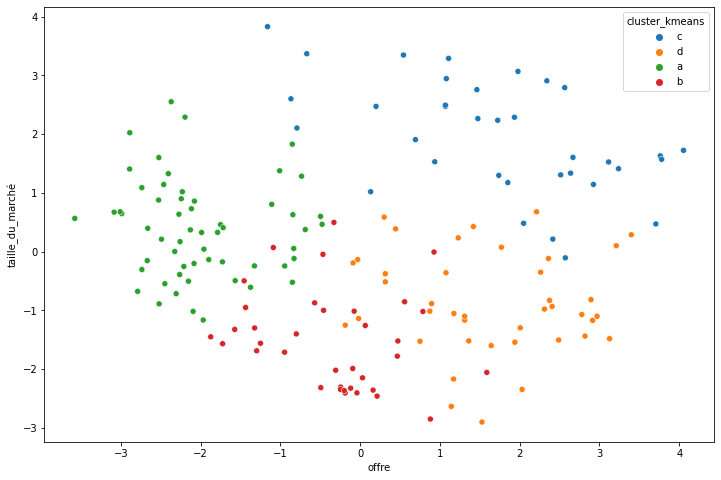

In [ ]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = data_pca["offre"], y = data_pca['taille_du_marché'], hue = data_pca['cluster_kmeans'])
plt.show()

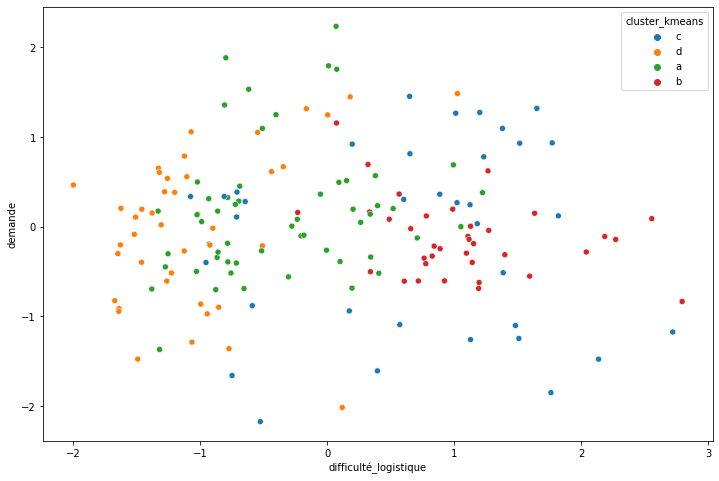

In [ ]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = data_pca['difficulté_logistique'], y = data_pca['demande'], hue = data_pca['cluster_kmeans'])
plt.show()

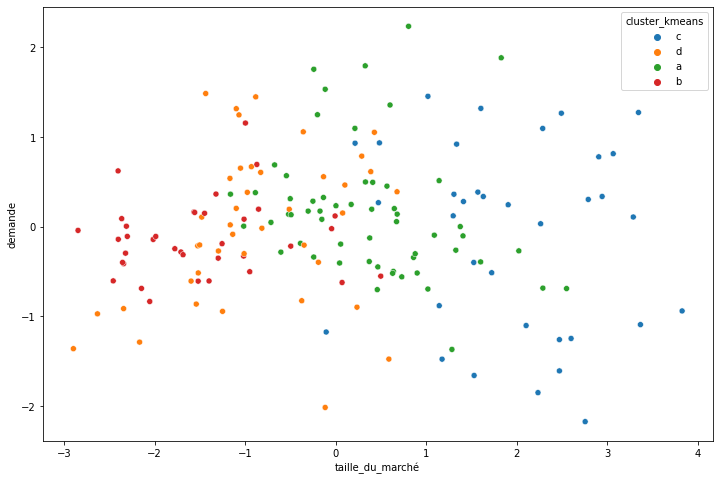

In [ ]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = data_pca['taille_du_marché'], y = data_pca['demande'], hue = data_pca['cluster_kmeans'])
plt.show()

In [ ]:
X_proj = data_pca.values
clusters = data_pca['cluster_kmeans']

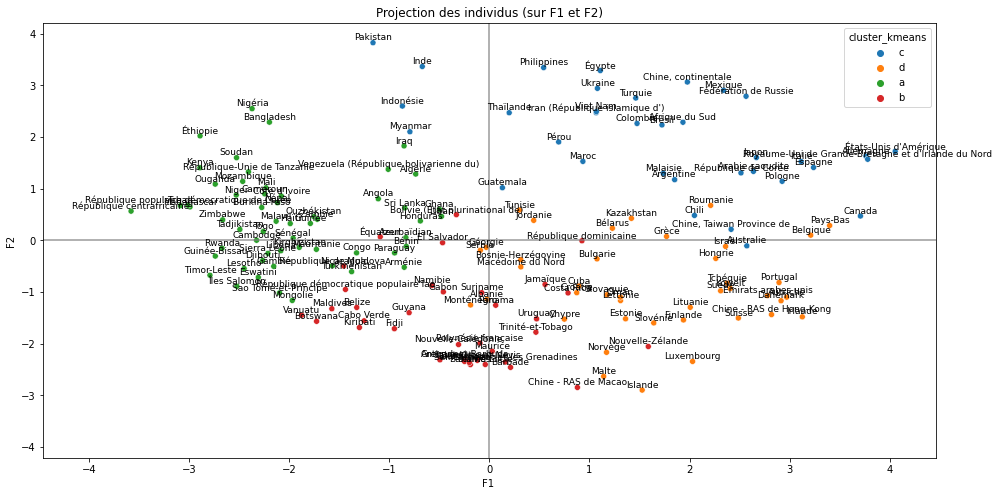

In [ ]:
x_y = (0, 1)
display_factorial_planes(X_proj, x_y, labels=zones, clusters=clusters)

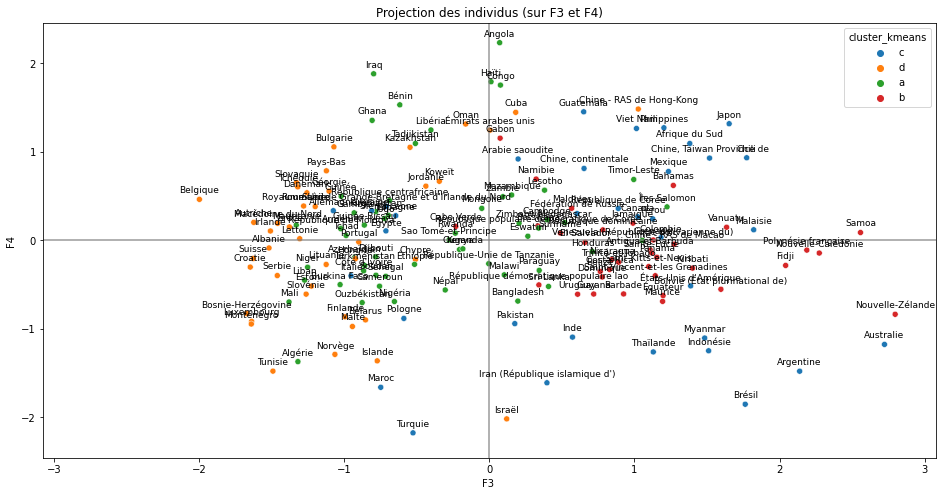

In [ ]:
x_y = (2, 3)
display_factorial_planes(X_proj, x_y, labels=zones, clusters=clusters)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

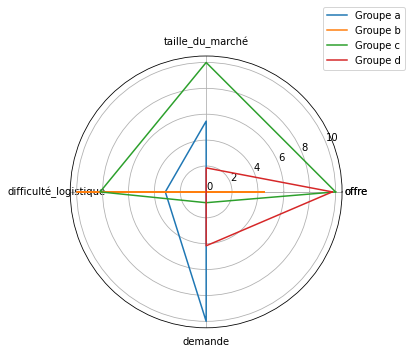

In [ ]:
grouped = data_pca.groupby('cluster_kmeans').mean()
grouped_scaled = min_max_scaler(grouped)
radar_graph(grouped_scaled)

**Clusters Analysis**

- Cluster a : Les pays dans ce cluster sont parmi ceux qui ont le plus besoin de viande de volailles. Les pays de ce cluster pourraient ouvrir une opportunité commerciale considérable si une bonne stratégie de vente est retenue, comme proposer des produits **bas de gamme**.
- Cluster b : Les pays dans ce cluster ne sont pas du tout intérssants de point de vue commercial, **à éviter**.
- Cluster c : Ce cluster est particulier. Les pays dans ce cluster peuvent être ciblés, mais ça sera un **vrai challenge**. L'économie d'échelle pourrait être mise à profit, si jamais, car ils ont une très grande population. Attention, ils sont fragiles politiqument.
- Cluster d : Ce cluster sera plutôt prioritaire. Il représente les pays les plus intérssants. ce seront propablement les clients naturels de nos produits. Il peuvent ouvrire une bonne opportunité commerciale à proximité. Penser à proposer des produits **haut de gamme**.

Enfin, Voici une liste des pays de chaque cluster et la distribution des variables au sein de chacune.

In [ ]:
for cluster in data_pca['cluster_kmeans'].unique():
  countries = list(data_pca[data_pca['cluster_kmeans'] == cluster].index)
  print('Cluster :', cluster)
  print('Nombre de pays : ', len(countries))
  print(countries)
  print('\n')

Cluster : c
Nombre de pays :  35
['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine', 'Australie', 'Brésil', 'Canada', 'Chili', 'Chine, Taiwan Province de', 'Chine, continentale', 'Colombie', 'Espagne', 'Fédération de Russie', 'Guatemala', 'Inde', 'Indonésie', "Iran (République islamique d')", 'Italie', 'Japon', 'Malaisie', 'Maroc', 'Mexique', 'Myanmar', 'Pakistan', 'Philippines', 'Pologne', 'Pérou', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'République de Corée', 'Thaïlande', 'Turquie', 'Ukraine', 'Viet Nam', 'Égypte', "États-Unis d'Amérique"]


Cluster : d
Nombre de pays :  41
['Albanie', 'Autriche', 'Belgique', 'Bosnie-Herzégovine', 'Bulgarie', 'Bélarus', 'Chine - RAS de Hong-Kong', 'Chypre', 'Croatie', 'Cuba', 'Danemark', 'Estonie', 'Finlande', 'Grèce', 'Géorgie', 'Hongrie', 'Irlande', 'Islande', 'Israël', 'Jordanie', 'Kazakhstan', 'Koweït', 'Lettonie', 'Lituanie', 'Luxembourg', 'Macédoine du Nord', 'Malte', 'Monténégro', 'Norvège', 'Oman', 'Pays-Bas', 'Port

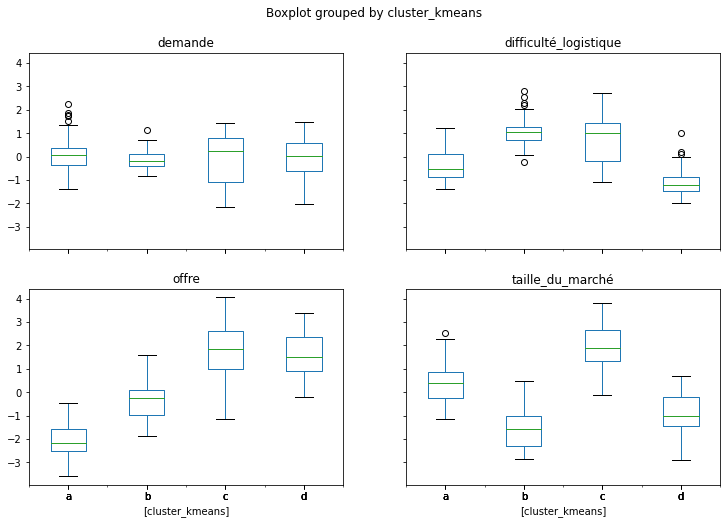

In [ ]:
data_pca.boxplot(by='cluster_kmeans', grid=False, figsize=(12, 8))
plt.show()